In [1]:
from jetcam.csi_camera import CSICamera

try:
    camera # kijk of var gedefinieerd is
except NameError: # zo niet, maak 'm aan
    camera = CSICamera(width=224, height=224, capture_fps=5)
else: # zo ja, doe niks
    pass

Fix audio als dat het niet doet door ~/fixaudio.sh te runnen op de bot. Mogelijk werkt het volgende:

In [80]:
# !pwd
#hcitool -i hci0 scan && ~/fixaudio.sh

Run 1x na aanzetten

In [6]:
import ipywidgets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg

image_widget = ipywidgets.Image(format='bmp')
# image_widget.value = bgr8_to_jpeg(image)

display(image_widget)

camera.running = True

def update_image(change):
    image = change['new']
    image_widget.value = bgr8_to_jpeg(image)
    camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
    
camera.observe(update_image, names='value')

import traitlets

camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
camera.unobserve(update_image, names='value')

Image(value=b'', format='bmp')

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def showplot(img, edges, lines=[], circles=[]):
    images = [img, edges]
    location = [121,122]
    for loc, edge_image in zip(location, images):
        plt.subplot(loc)
        for line in lines:
            plt.plot(line[0], line[1], color=line[2])
        if len(circles):
            for circle in circles[0]:
                plt.gca().add_artist(plt.Circle((circle[0], circle[1]), radius=circle[2]))
        plt.imshow(edge_image, cmap='gray')

def edge_detection(image, show):
    edges_detected = cv2.Canny(image, 110, 250)
    if show:
        showplot(image, edges_detected)
    return edges_detected


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0, 255, 255]], dtype=uint8)

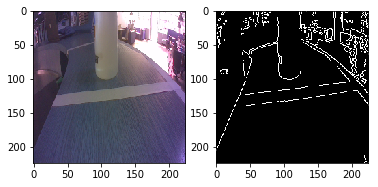

In [12]:
edge_detection(camera.value, True)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255   0   0]
 [  0   0   0 ...   0   0   0]]


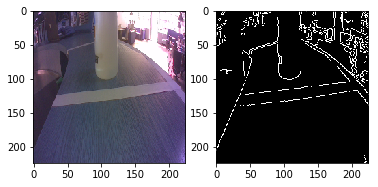

In [13]:
edges = np.array(edge_detection(camera.value, True))
print(edges)

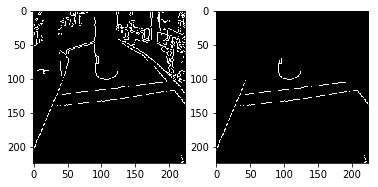

In [14]:
def region(image, includeBottom=False, returnTrip=False):
    height, width = image.shape
    x = 0
    if returnTrip == False:
        x = 20
    if includeBottom:
        triangle = np.array([
                           [(20+x, 170), (40+x, 90), (100+x, 60), (125+x, 60), (width-40+x, 170), (20+x, 170)]
                           ])
    else:
        triangle = np.array([
                           [(0, height), (0, height-100), (width//2, height//2-50), (width, height-100), (width, height)]
                           ])
    
    mask = np.zeros_like(image)
    
    mask = cv2.fillPoly(mask, triangle, 255)
    
    mask = cv2.bitwise_and(image, mask)
    return mask

isolated = region(edges)
showplot(edges, isolated)

In [19]:
def findlines(edges, steering):
    lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), 40, 5)
    #print(lines)
    if lines is None:
        return [], [], []
    vertpos = [] # linksonder -> rechtsboven
    vertneg = [] # linksboven -> rechtsonder
    hor = []
    for line in lines:
        l = line[0]
        if l[2] < l[0]:
            l = [l[2], l[3], l[0], l[1]]
        if l[3] - l[1] != 0:
            delta = (l[2] - l[0]) / (l[3] - l[1])
        else:
            delta = np.sign(l[2] - l[0]) * 1e9
        #print('delta', delta, l[2]-l[0], l[3]-l[1])
        if -1.3 < delta < 0:
            # linksonder -> rechtsboven, steiler dan 45grd
            vertpos.append(l)
            steering[0] = delta
        elif 0 < delta < 1.3:
            # linksboven -> rechtsonder, steiler dan 45grd
            vertneg.append(l)
            steering[0] = delta
        elif delta >= 1.5:
            # linksonder -> rechtsboven, minder steil dan 45grd
            hor.append(l)
        elif delta <= 1.5:
            # linksboven -> rechtsonder, minder steil dan 45grd
            hor.append(l)

    return vertpos, vertneg, hor

In [20]:
def checkForObstacles(temp_isolated, returnTrip=False):
    return checkForPixels(temp_isolated, returnTrip) > 300
    circles = cv2.HoughCircles(temp_isolated, cv2.HOUGH_GRADIENT, 1, 20, param1=1000, param2=6, minRadius=18, maxRadius=28)
#     print(circles)
    if type(circles) == type(None): 
        circles = []
        print("laat maar, geen obstakel")
        cardata['foundobjects'] = 0
        return False
    else:
        print("iets gezien maar weet nie of da is", cardata['foundobjects'])
        if cardata['foundobjects'] >= 3:
            cardata['foundobjects'] = 0
            return True
        else:
            cardata['foundobjects'] += 1
            return False
#     showplot(edges, isolated, circles=circles)

def linelen(l):
    return ((l[0]-l[2])**2 + (l[1]-l[3])**2)**0.5

def checkForPixels(edges, returnTrip=False):
    isolated = region(edges, True, returnTrip)
#     isolated = region(isolated, True)
    v, V, h = findlines(isolated, [0])
    edgepx = int(np.sum(isolated)//255)
    for l in v:
        edgepx -= linelen(l)
    for l in V:
        edgepx -= linelen(l)
    for l in h:
        edgepx -= linelen(l)
    print(v, V, h, edgepx)
    return edgepx

[] [] [array([ 52, 122, 123, 114], dtype=int32), array([ 48, 139,  99, 133], dtype=int32)] 184.19898898254394
184.19898898254394


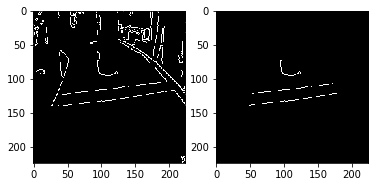

In [26]:
edges = np.array(edge_detection(camera.value, True))
isolated = region(edges, True)
circles = cv2.HoughCircles(isolated, cv2.HOUGH_GRADIENT, 1, 20, param1=2500, param2=7, minRadius=18, maxRadius=28)
#     print(circles)
if type(circles) == type(None): 
    circles = []
showplot(edges, isolated, circles=circles)

objpx = checkForPixels(edges)
print(objpx)

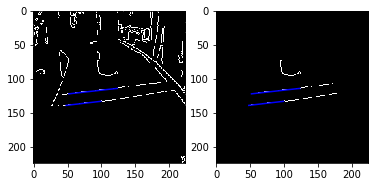

In [27]:
steering = [0]
vertpos, vertneg, hor = findlines(isolated, steering)
lines = []
for i in range(len(vertpos)):
    lines.append(((vertpos[i][0], vertpos[i][2]), (vertpos[i][1], vertpos[i][3]), 'r'))
for i in range(len(vertneg)):
    lines.append(((vertneg[i][0], vertneg[i][2]), (vertneg[i][1], vertneg[i][3]), 'g'))
for i in range(len(hor)):
    lines.append(((hor[i][0], hor[i][2]), (hor[i][1], hor[i][3]), 'b'))

showplot(edges, isolated, lines)

In [23]:
from jetracer.nvidia_racecar import NvidiaRacecar
import time
import random
car = NvidiaRacecar()
cardata = {}

def resetCardata():
    cardata['distance'] = 0
    cardata['starttime'] = int(time.time())
    cardata['foundobjects'] = 0
    cardata['foundline'] = False
    cardata['sections'] = 0
    car.throttle = 0
    car.steering_offset = 0.22
    
resetCardata()

def drive(throttle):
    # keep track of distance driven
    cardata['distance'] -= (int(time.time()) - cardata['starttime']) * car.throttle
    # actually drive a distance
    cardata['starttime'] = int( time.time() )
    car.throttle = throttle

In [6]:
import Jetson.GPIO as GPIO
import time

# Check if the button is pressed for >= 1 sec
def checkButton():
    # Pin Definitions
    input_pin = "LCD_BL_PW"  # BCM pin 18, BOARD pin 126

    prev_value = None

    # Pin Setup:
    GPIO.setmode(GPIO.TEGRA_SOC)  # BCM pin-numbering scheme from Raspberry Pi
    GPIO.setup(input_pin, GPIO.IN)  # set pin as an input pin
    print("Starting demo now! Press CTRL+C to exit")
    start_time = int(time.time())
    try:
        while True:
    #         print(input_pin)
            value = GPIO.input(input_pin)
            if value != prev_value:
                if value == GPIO.HIGH:
                    print(int(time.time()) - start_time)
                    if (int(time.time()) - start_time > 2):
                        print("Hoera")
                        break;
                    value_str = "HIGH"
                    start_time = int(time.time())
                else:
                    value_str = "LOW"
                prev_value = value
            time.sleep(0.3)
    finally:
        GPIO.cleanup()
    return

Starting demo now! Press CTRL+C to exit
0
5
Hoera


In [24]:
import IPython.display as display
import json
import math

def get_sound(s_type, time):
    sounds = json.load(open("./sounds/sounds.json"))
    
    time = math.ceil(time / 10)

    if (time >= len(sounds[s_type])):
        time = len(sounds[s_type]) -1

    time_code = list(sounds[s_type].keys())[time]

    options = len(sounds[s_type][time_code])
    option = random.randint(0, options-1)

    return sounds[s_type][time_code][option]

def playsound(file):
    display.display(display.Audio("sounds/"+file, autoplay=True))

# playsound('The bar is open.wav')
# time.sleep(5)
# playsound('fietsbel.wav')

In [93]:
def changeCourse(img):
    steering = [0]
    vertpos, vertneg, hor = findlines(isolated, steering)
    steer = max(-1.0, min(1.0, steering[0]))
    car.steering = steering[0]
    return hor

def countSections(lines):
    #if len(lines) > 0:
    #    print(lines, lines[0][1], 100 < lines[0][1] < 200, cardata['foundline'], (int(time.time()) - cardata['starttime']) * car.throttle + cardata['distance'])
    #print(lines[0])
    if cardata['foundline']:
        if (int(time.time()) - cardata['starttime']) * (car.throttle) + cardata['distance'] > (0.3):
            # start detecting lines again after ~40cm
            cardata['foundline'] = False
    elif len(lines) > 0:
        for l in lines:
            if 100 < l[1] < 200:
                print('found section:', lines)
                drive(car.throttle) # zet cardata op huidige stand
                cardata['foundline'] = True
                cardata['sections'] += 1
                cardata['distance'] = 0
                cardata['starttime'] = int(time.time())
                return True
    return False
    
drive(-0)

In [94]:
car.throttle=0
print(cardata)

{'distance': 0.0, 'starttime': 1654006128, 'foundobjects': 0, 'foundline': False, 'sections': 0}


In [95]:
while True and 0:
    edges = np.array(edge_detection(camera.value, True))
    isolated = region(edges)
    hor = changeCourse(isolated)
    print(hor)
    time.sleep(0.5)

Als we dan nu alles combineren, kan de bot binnen de lijntjes rijden

In [ ]:
## dit hoorde in een functie te staan maar dat werkte om een of andere reden niet?!? ##
import random

#Input
goToSection = 0

resetCardata()
driveSpeed = -0.45
drive(driveSpeed)
startRegion = cardata['sections']
while not (cardata['sections'] - startRegion == goToSection):
    edges = np.array(edge_detection(camera.value, True))
    isolated = region(edges)
    hor = changeCourse(isolated)
    newSection = countSections(hor) # geeft aan in print() als hij een nieuwe sectie heeft gevonden.
    isolatedObj = region(edges, True)
    if checkForObstacles(isolatedObj):
        print("OBSTACLE FOUND")
        drive(0)
        time.sleep(0.5)
        if checkForObstacles(isolatedObj):
            playsound(get_sound("obstacle", 0))
            time.sleep(2)
            continue
        else:
            drive(driveSpeed)
#     while(checkForObstacles(isolated)):
#         edges = np.array(edge_detection(camera.value, True))
#         isolated = region(edges)
#         drive(0)
# #         PLAY SOUND
#         if(newSection):
#             print("OBSTACLE FOUND")
#             playsound(get_sound("obstacle", 10))
    drive(driveSpeed)
    time.sleep(0.5)
    drive(car.throttle) # dit updatet de cardata['distance'] naar de huidige afstand
    #print(cardata)
drive(0)
playsound(get_sound("delivery", 0))
# Wait untill delivery complete
#
#
# Await a button press
checkButton()
driveSpeed = -0.36

# Return to begin
drive(driveSpeed)
startRegion = cardata['sections'] - 1
while not (cardata['sections'] - startRegion == goToSection):
    edges = np.array(edge_detection(camera.value, True))
    isolated = region(edges)
#     showplot(edges, isolated)
    hor = changeCourse(isolated)
    newSection = countSections(hor) # geeft aan in print() als hij een nieuwe sectie heeft gevonden.
    isolatedObj = region(edges, True)
    if checkForObstacles(isolatedObj, True):
        print("OBSTACLE FOUND")
        drive(0)
        time.sleep(0.5)
        if checkForObstacles(isolatedObj, True):
            playsound(get_sound("obstacle", 0))
            time.sleep(2)
            continue
        else:
            drive(driveSpeed)
#     while(checkForObstacles(isolated)):
#         edges = np.array(edge_detection(camera.value, True))
#         isolated = region(edges)
#         drive(0)
# #         print("OBSTACLE FOUND")
#         # PLAY SOUND
#         if(newSection):
#             print("OBSTACLE FOUND")
#             playsound(get_sound("obstacle", 10))
    drive(driveSpeed)
    time.sleep(0.5)
    drive(car.throttle) # dit updatet de cardata['distance'] naar de huidige afstand
    #print(cardata)
print("Delivery done!")
drive(0)

Starting demo now! Press CTRL+C to exit
2
Hoera
found section: [array([131, 144, 190, 144], dtype=int32)]
[] [array([ 77, 142, 115, 208], dtype=int32)] [array([131, 144, 190, 144], dtype=int32)] 1080.842268941361
OBSTACLE FOUND
[] [array([ 77, 142, 115, 208], dtype=int32)] [array([131, 144, 190, 144], dtype=int32)] 1080.842268941361


[] [] [array([118, 151, 194, 151], dtype=int32), array([148, 144, 189, 144], dtype=int32), array([154, 149, 195, 149], dtype=int32)] 1113.0
OBSTACLE FOUND
[] [] [array([118, 151, 194, 151], dtype=int32), array([148, 144, 189, 144], dtype=int32), array([154, 149, 195, 149], dtype=int32)] 1113.0


[] [] [array([125, 141, 199, 141], dtype=int32), array([142, 135, 194, 135], dtype=int32), array([ 40, 166,  86, 158], dtype=int32), array([126, 143, 189, 143], dtype=int32), array([139, 156, 180, 156], dtype=int32)] 1097.309529880285
OBSTACLE FOUND
[] [] [array([125, 141, 199, 141], dtype=int32), array([142, 135, 194, 135], dtype=int32), array([ 40, 166,  86, 158], dtype=int32), array([126, 143, 189, 143], dtype=int32), array([139, 156, 180, 156], dtype=int32)] 1097.309529880285


[] [] [array([  0, 161,  59, 150], dtype=int32), array([142, 145, 196, 145], dtype=int32), array([159, 136, 201, 136], dtype=int32), array([135, 147, 194, 147], dtype=int32)] 1099.9833356475053
OBSTACLE FOUND
[] [] [array([  0, 161,  59, 150], dtype=int32), array([142, 145, 196, 145], dtype=int32), array([159, 136, 201, 136], dtype=int32), array([135, 147, 194, 147], dtype=int32)] 1099.9833356475053


[] [] [array([147, 137, 211, 137], dtype=int32), array([136, 139, 210, 139], dtype=int32), array([131, 143, 201, 143], dtype=int32), array([154, 136, 200, 127], dtype=int32), array([158, 136, 215, 126], dtype=int32)] 1180.2572882340469
OBSTACLE FOUND
[] [] [array([147, 137, 211, 137], dtype=int32), array([136, 139, 210, 139], dtype=int32), array([131, 143, 201, 143], dtype=int32), array([154, 136, 200, 127], dtype=int32), array([158, 136, 215, 126], dtype=int32)] 1180.2572882340469


[] [] [array([145, 142, 220, 128], dtype=int32), array([147, 144, 201, 144], dtype=int32)] 594.7045217591501
OBSTACLE FOUND
[] [] [array([145, 142, 220, 128], dtype=int32), array([147, 144, 201, 144], dtype=int32)] 594.7045217591501


[] [array([121, 161, 161, 207], dtype=int32)] [array([170, 139, 213, 139], dtype=int32), array([159, 143, 203, 143], dtype=int32), array([122, 151, 193, 151], dtype=int32), array([127, 160, 187, 160], dtype=int32), array([128, 144, 196, 149], dtype=int32), array([135, 155, 192, 155], dtype=int32)] 935.8574216485642
OBSTACLE FOUND
[] [array([121, 161, 161, 207], dtype=int32)] [array([170, 139, 213, 139], dtype=int32), array([159, 143, 203, 143], dtype=int32), array([122, 151, 193, 151], dtype=int32), array([127, 160, 187, 160], dtype=int32), array([128, 144, 196, 149], dtype=int32), array([135, 155, 192, 155], dtype=int32)] 935.8574216485642


[] [] [] 1263
OBSTACLE FOUND
[] [] [] 1263


[] [] [] 1024
OBSTACLE FOUND
[] [] [] 1024


[] [] [array([136, 136, 182, 136], dtype=int32)] 1101.0
OBSTACLE FOUND
[] [] [array([136, 136, 182, 136], dtype=int32)] 1101.0


[] [] [array([124, 140, 172, 140], dtype=int32), array([126, 132, 184, 132], dtype=int32), array([142, 120, 191, 120], dtype=int32), array([138, 143, 185, 143], dtype=int32), array([152, 170, 152, 110], dtype=int32)] 1091.0
OBSTACLE FOUND
[] [] [array([124, 140, 172, 140], dtype=int32), array([126, 132, 184, 132], dtype=int32), array([142, 120, 191, 120], dtype=int32), array([138, 143, 185, 143], dtype=int32), array([152, 170, 152, 110], dtype=int32)] 1091.0


[] [] [array([150, 133, 194, 133], dtype=int32), array([131, 129, 197, 129], dtype=int32), array([124, 125, 167, 125], dtype=int32), array([121, 131, 196, 131], dtype=int32)] 1046.0
OBSTACLE FOUND
[] [] [array([150, 133, 194, 133], dtype=int32), array([131, 129, 197, 129], dtype=int32), array([124, 125, 167, 125], dtype=int32), array([121, 131, 196, 131], dtype=int32)] 1046.0


[] [array([ 95, 157, 135, 214], dtype=int32)] [array([126, 132, 196, 132], dtype=int32), array([135, 129, 196, 129], dtype=int32)] 1049.3652385657851
OBSTACLE FOUND
[] [array([ 95, 157, 135, 214], dtype=int32)] [array([126, 132, 196, 132], dtype=int32), array([135, 129, 196, 129], dtype=int32)] 1049.3652385657851


[] [] [array([140, 135, 205, 135], dtype=int32), array([147, 133, 207, 133], dtype=int32)] 1052.0
OBSTACLE FOUND
[] [] [array([140, 135, 205, 135], dtype=int32), array([147, 133, 207, 133], dtype=int32)] 1052.0


[] [array([106, 160, 151, 223], dtype=int32), array([130, 148, 167, 188], dtype=int32)] [array([147, 125, 208, 125], dtype=int32), array([138, 132, 187, 132], dtype=int32), array([153, 140, 193, 140], dtype=int32), array([132, 127, 208, 127], dtype=int32)] 820.0905416933151
OBSTACLE FOUND
[] [array([106, 160, 151, 223], dtype=int32), array([130, 148, 167, 188], dtype=int32)] [array([147, 125, 208, 125], dtype=int32), array([138, 132, 187, 132], dtype=int32), array([153, 140, 193, 140], dtype=int32), array([132, 127, 208, 127], dtype=int32)] 820.0905416933151


[] [array([108, 161, 152, 222], dtype=int32)] [array([147, 124, 220, 124], dtype=int32), array([160, 144, 213, 144], dtype=int32), array([138, 131, 204, 131], dtype=int32), array([168, 121, 218, 121], dtype=int32)] 858.7869692141048
OBSTACLE FOUND


In [76]:
snd = get_sound("obstacle", 0)
print(snd)
playsound(snd)

PICK_UP.wav


In [ ]:
isolated = region(edges)
hor = changeCourse(isolated)
print(hor)

In [ ]:
print(cardata['sections'])

KeyboardInterrupt: 

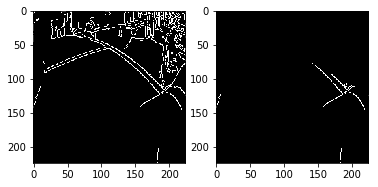

In [52]:
driveSections()